## Step 1 : Project Overview and Import Libraries

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


In [2]:
#This code is necessary to allow memory growth for GPU, otherwise model will not be able to access required memory and stop running
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Step 2 : Load and Preprocess the Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

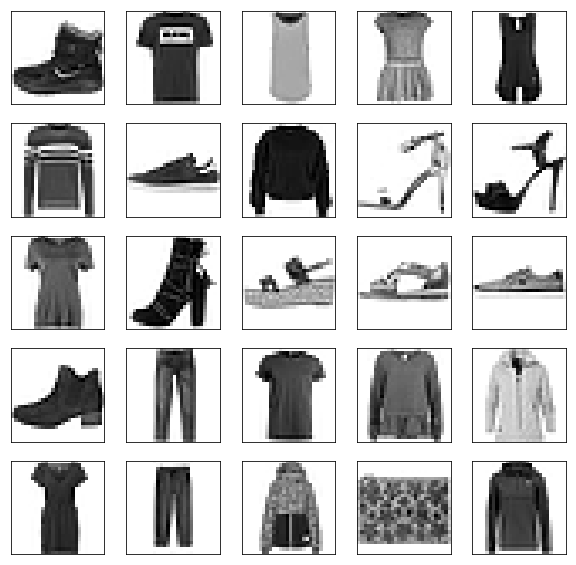

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

## Step 3: Create Batches of Training Data

In [5]:
batch_size=32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

### NOTES

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

## Step 4 : Build the Generator Network 

In [6]:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[num_features]),
    keras.layers.Reshape([7,7,128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding='same', activation='tanh')
])

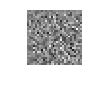

In [7]:
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(noise, training=False)
plot_utils.show(generated_image, 1)

## Task 5: Build the Discriminator Network for DCGAN

In [8]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape=[28,28,1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5042199]], shape=(1, 1), dtype=float32)


## Step 6 : Compile the DCGAN

In [10]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

## Step 7 : Define Training Procedure

In [11]:
seed = tf.random.normal(shape=[batch_size, num_features])

In [12]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    
    for epoch in tqdm(range(epochs)):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        
        for real_images_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            fake_images = generator(noise)
            X_fake_and_real = tf.concat([fake_images, real_images_batch], axis=0)
            y1 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
            
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            discriminator.trainable = False
            
            y2 = tf.constant([[1.]]*batch_size)
            gan.train_on_batch(noise, y2)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [46]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('Images at epoch/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Step 8 : Train the DCGAN

In [14]:
x_train.shape

(60000, 28, 28)

In [15]:
x_train_reshaped = x_train.reshape(-1,28,28,1)*2.-1.

In [16]:
batch_size=32
dataset = tf.data.Dataset.from_tensor_slices(x_train_reshaped).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

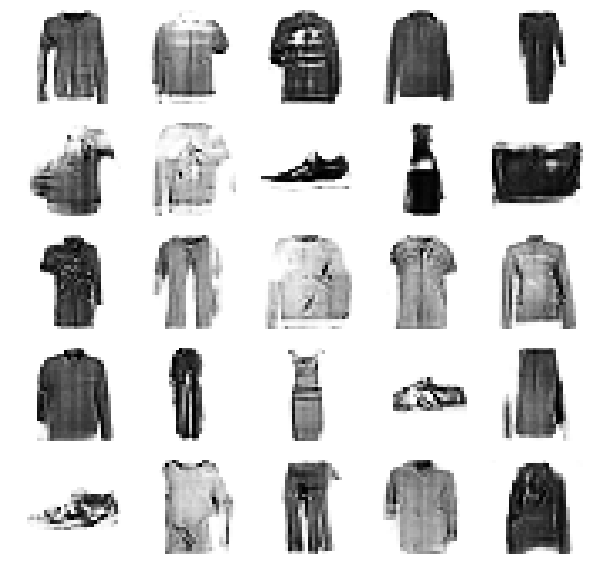

Wall time: 1h 26min 3s


In [17]:
%%time

train_dcgan(gan, dataset, batch_size, num_features, epochs=50)

## Step 9 : Generate Synthetic Images

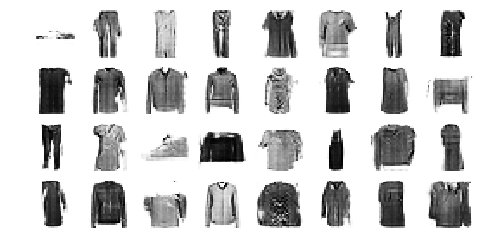

In [19]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
plot_utils.show(generated_images, 8)

In [48]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

gif_file = 'clothes.gif'

with imageio.get_writer(gif_file, mode='I') as writer:
    filenames = glob.glob('Images at epoch/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
IPython.display.Image(url=gif_file)